In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

In [2]:
prob = .25

dropout = nn.Dropout(p=prob)
x = torch.ones(10)

y = dropout(x)
print(x)
print(y*(1-prob))
print(y)
print(torch.mean(y))


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 0., 1., 1., 0., 0., 1., 1., 1.])
tensor([1.3333, 1.3333, 0.0000, 1.3333, 1.3333, 0.0000, 0.0000, 1.3333, 1.3333,
        1.3333])
tensor(0.9333)


In [3]:
dropout.eval()
y = dropout(x)
print(y)
print(torch.mean(y))

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor(1.)


In [4]:
nPerCluster = 200

th = np.linspace(0, 4*np.pi, nPerCluster)
r1 = 10
r2 = 15


In [5]:
a = [r1*np.cos(th) + np.random.randn(nPerCluster)*3,
     r1*np.sin(th) + np.random.randn(nPerCluster)]

b = [r2*np.cos(th) + np.random.randn(nPerCluster),
     r2*np.sin(th) + np.random.randn(nPerCluster)*3]

labels_np = np.vstack((np.zeros((nPerCluster,1)), np.ones((nPerCluster,1))))

data_np = np.hstack((a,b)).T

data = torch.tensor(data_np, dtype=torch.float32)
labels = torch.tensor(labels_np, dtype=torch.float32)

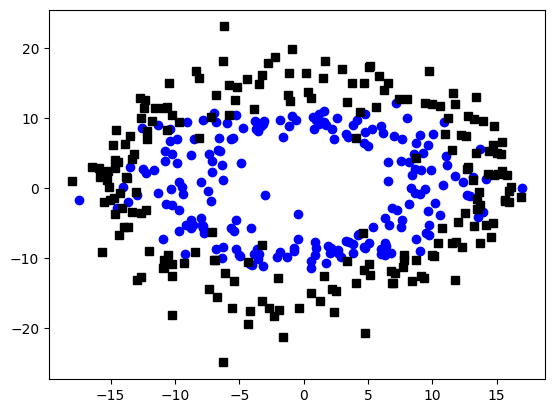

In [6]:
plt.plot(data[np.where(labels==0)[0], 0],data[np.where(labels==0)[0], 1],"bo")
plt.plot(data[np.where(labels==1)[0], 0],data[np.where(labels==1)[0], 1],"ks")


In [7]:
np.where(labels==0)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=.2)

trainData = TensorDataset(X_train, y_train)
testData = TensorDataset(X_test, y_test)

batchSize = 16
train_loader = DataLoader(trainData, batch_size=testData.tensors[0].shape[0], shuffle=True)
test_loader = DataLoader(testData, batch_size=testData.tensors[0].shape[0])

In [9]:
class annDropout(nn.Module):
    def __init__(self, dropoutRate):
        super().__init__()
        
        self.input = nn.Linear(2, 128)
        self.hidden = nn.Linear(128, 128)
        self.output = nn.Linear(128,1)
        
        self.dr = dropoutRate
        
    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.dropout(x, p=self.dr, training=self.training)
        
        x = F.relu(self.hidden(x))
        x = F.dropout(x, p=self.dr, training=self.training)
        
        x = self.output(x)
        
        return x

In [10]:
tempnet = annDropout(.25)

tempdata = torch.randn((10,2))
yhat = tempnet(tempdata)
yhat


tensor([[0.3898],
        [0.1054],
        [0.4052],
        [0.1342],
        [0.2186],
        [0.0921],
        [0.3733],
        [0.5665],
        [0.1774],
        [0.1209]], grad_fn=<AddmmBackward0>)

In [11]:
def createModel(dropoutRate):
    ann = annDropout(dropoutRate)
    
    lossfun = nn.BCEWithLogitsLoss()
    
    optimizer = torch.optim.SGD(ann.parameters(), lr=.002)
    
    
    return ann, lossfun, optimizer

In [12]:
def trainModel(ann, lossfun, optimizer):
    trainAcc = []
    testAcc = []
    
    
    for epoch in range(1000):
        ann.train()
        batchAcc = []
        for X, y in train_loader:
            
            y_pred = ann(X)
            
            loss = lossfun(y_pred, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            acc = 100*torch.mean(((y_pred>0.5) == y).float()).item()
            batchAcc.append(acc)
            
        trainAcc.append(np.mean(batchAcc))
        
        X,y = next(iter(test_loader))
        ann.eval()
        y_pred = ann(X)
        acc = 100*torch.mean(((y_pred>0.5) == y).float()).item()
        testAcc.append(acc)
        
    return trainAcc, testAcc
        

In [13]:
ann, lossfun, optimizer = createModel(0.25)
test, train = trainModel(ann, lossfun, optimizer)

In [14]:
def smooth(x, k=5):
    return np.convolve(x, np.ones(k)/k, mode="same")

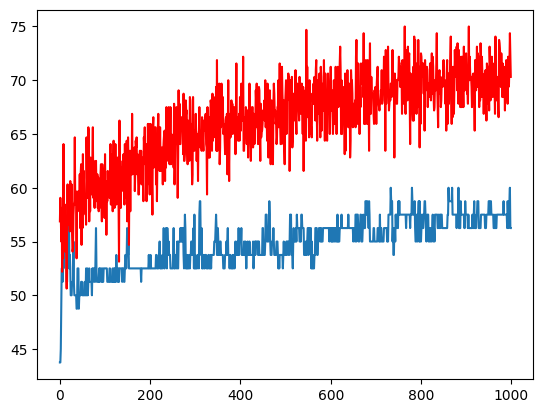

In [15]:
plt.plot(train)
plt.plot(test, "r")

In [ ]:
dropoutRates = np.linspace(0,1,11)
results = np.zeros((len(dropoutRates), 2))

for di in range(len(dropoutRates)):
    ann, lossfun, optimizer = createModel(dropoutRates[di])
    trainAcc, testAcc = trainModel(ann, lossfun, optimizer)
    
    results[di,0] = np.mean(trainAcc[-100:])
    results[di,1] = np.mean(testAcc[-100:])
    

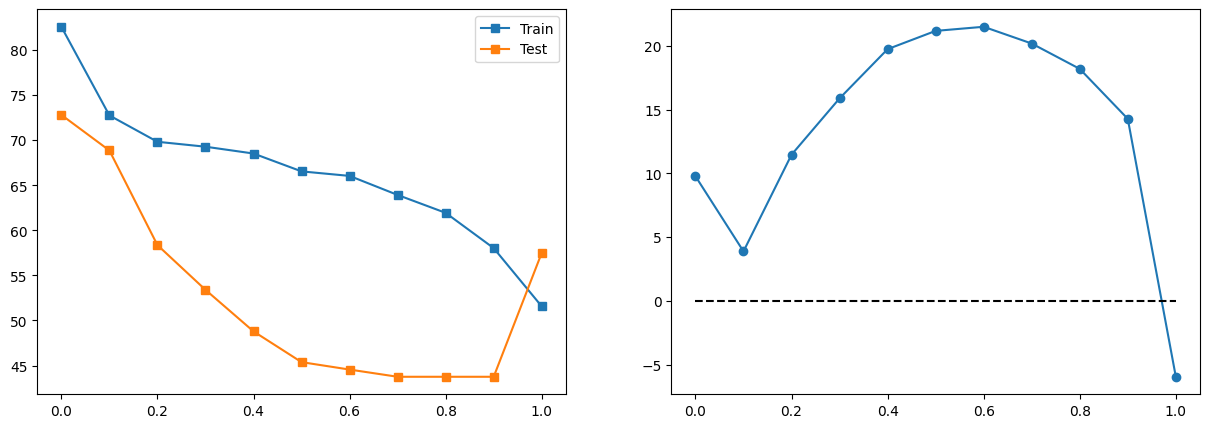

In [17]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(dropoutRates, results, "s-")
ax[0].legend(["Train", "Test"])

ax[1].plot(dropoutRates, -np.diff(results, axis=1), "o-")
ax[1].plot(np.linspace(0,1,20), np.zeros(20), "k--")

In [18]:
class annDropout(nn.Module):
    def __init__(self, dropoutRate):
        super().__init__()
        
        self.input = nn.Linear(4, 12)
        self.hidden = nn.Linear(12, 12)
        self.output = nn.Linear(12,3)
        
        self.dr = dropoutRate
        
    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.dropout(x, p=self.dr, training=self.training)
        
        x = F.relu(self.hidden(x))
        x = F.dropout(x, p=self.dr, training=self.training)
        
        x = self.output(x)
        
        return x

In [19]:
def createModel(dropoutRate):
    ann = annDropout(dropoutRate)
    
    lossfun = nn.CrossEntropyLoss()
    
    optimizer = torch.optim.SGD(ann.parameters(), lr=.003)
    
    
    return ann, lossfun, optimizer

def trainModel(ann, lossfun, optimizer):
    trainAcc = []
    testAcc = []
    
    
    for epoch in range(1000):
        ann.train()
        batchAcc = []
        for X, y in train_loader:
            
            y_pred = ann(X)
            
            loss = lossfun(y_pred, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            matches = (torch.argmax(y_pred, axis=1) == y).float()
            acc = torch.mean(matches)
            batchAcc.append(acc)
            
        trainAcc.append(np.mean(batchAcc))
        
        X,y = next(iter(test_loader))
        ann.eval()
        y_pred = ann(X)
        matches = (torch.argmax(y_pred, axis=1) == y).float()
        acc = torch.mean(matches)
        testAcc.append(acc)
        
    return trainAcc, testAcc
        

In [23]:
import seaborn as sns
iris = sns.load_dataset("iris")

data = torch.tensor(iris[iris.columns[0:4]].values).float()

labels = torch.zeros(len(data), dtype=torch.long)
labels[iris.species =="versicolor"] = 1
labels[iris.species=="virginica"] = 2

X_train, X_test, y_train, y_test = train_test_split(data, labels, train_size=.8)

trainData = TensorDataset(X_train, y_train)
testData = TensorDataset(X_test, y_test)

train_loader = DataLoader(trainData, batch_size=16)
test_loader = DataLoader(testData, batch_size=labels.shape[0])

In [24]:
dropoutRates = np.linspace(0,1,21)
results = np.zeros((len(dropoutRates), 2))

for di in range(len(dropoutRates)):
    ann, lossfun, optimizer = createModel(dropoutRates[di])
    trainAcc, testAcc = trainModel(ann, lossfun, optimizer)
    
    results[di,0] = np.mean(trainAcc[-10:])
    results[di,1] = np.mean(testAcc[-10:])

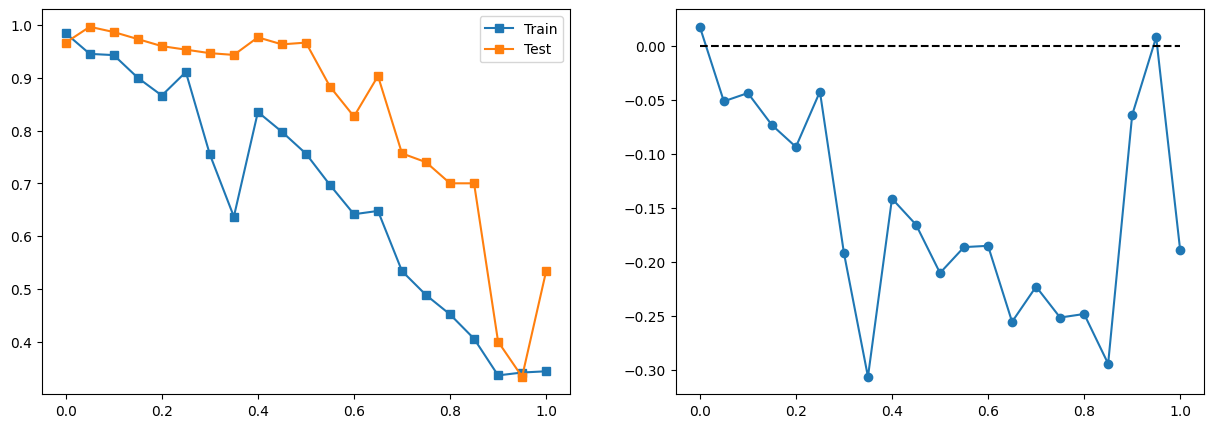

In [25]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(dropoutRates, results, "s-")
ax[0].legend(["Train", "Test"])

ax[1].plot(dropoutRates, -np.diff(results, axis=1), "o-")
ax[1].plot(np.linspace(0,1,20), np.zeros(20), "k--")